In [9]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic data generation

In [11]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [12]:
import pandas as pd

## Load transactions

In [13]:
# load dataset
data = pd.read_csv('data/uci/wine_quality-white.csv')
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


## Train model and synthesized data

In [14]:
from synthesized.core import BasicSynthesizer
from datetime import datetime


In [16]:
synthesizer = BasicSynthesizer(data=data, iterations=100000)
with synthesizer:
    print(datetime.now().strftime('%H:%M:%S'), flush=True)
    synthesizer.learn(data=data, verbose=10000)  # filenames=('dataset.tfrecords',)
    print(datetime.now().strftime('%H:%M:%S'), flush=True)
    synthesized = synthesizer.synthesize(n=10000)
    print(datetime.now().strftime('%H:%M:%S'), flush=True)

value types:
('fixed acidity', CategoricalValue(name='fixed acidity',categories=None,embedding_size=32,similarity_based=True,temperature=1.0,smoothing=0.1,moving_average=True))
('volatile acidity', ContinuousValue(name='volatile acidity',positive=None,integer=False))
('citric acid', ContinuousValue(name='citric acid',positive=None,integer=False))
('residual sugar', ContinuousValue(name='residual sugar',positive=None,integer=False))
('chlorides', ContinuousValue(name='chlorides',positive=None,integer=False))
('free sulfur dioxide', ContinuousValue(name='free sulfur dioxide',positive=None,integer=False))
('total sulfur dioxide', ContinuousValue(name='total sulfur dioxide',positive=None,integer=False))
('density', ContinuousValue(name='density',positive=None,integer=False))
('pH', ContinuousValue(name='pH',positive=None,integer=False))
('sulphates', ContinuousValue(name='sulphates',positive=None,integer=False))
('alcohol', ContinuousValue(name='alcohol',positive=None,integer=False))
('qua

## Display synthesized data

In [ ]:
synthesized.head(10)

# Visualization of original and synthetic data

In [ ]:
data['quality'].hist(bins=10, range=[0, 10])


In [ ]:
synthesized['quality'].hist(bins=10, range=[0, 10])

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(data['sulphates']) 
sns.distplot(synthesized['sulphates']);

In [ ]:
sns.distplot(data['residual sugar']) 
sns.distplot(synthesized['residual sugar']);

# Tests to confirm the utility of synthetic data 

In [18]:
from synthesized.testing.testing_environment import Testing, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import train_test_split
# prepare data
original, test = train_test_split(data, test_size=0.2)


In [20]:
synthesized['quality'] = synthesized['quality'].astype(int)

In [21]:
synthesized.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.9,0.215498,0.418981,1.634739,0.045165,32.668037,87.831329,0.995708,2.995935,0.522936,9.906588,5
1,4.4,0.500240,0.357665,7.558054,0.043202,49.008545,85.052002,0.995642,3.055593,0.587106,10.867803,4
2,9.0,0.459035,0.376528,5.003320,0.052902,32.388134,82.964088,0.996914,3.115908,0.497448,10.492731,5
3,7.3,0.192234,0.468068,2.295779,0.025477,31.043564,104.711388,0.996780,3.523579,0.445338,12.615517,7
4,6.9,0.348164,0.400718,14.409437,0.060045,4.492810,59.059841,1.001953,2.887960,0.501650,7.652475,6


In [24]:
testing = Testing(data, test, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
    'account_id':  ColumnType.CONTINUOUS
})

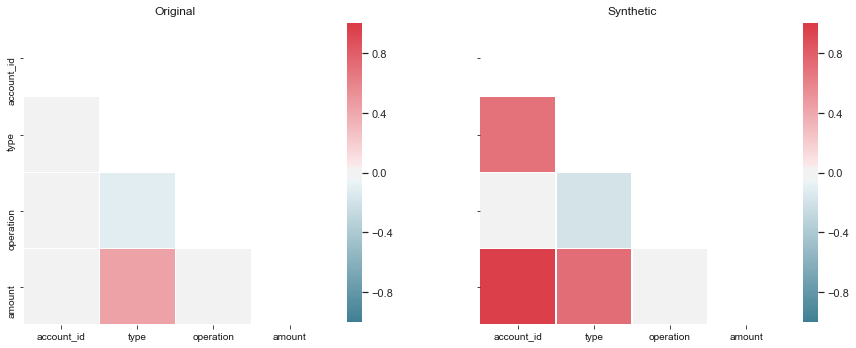

In [25]:
testing.show_corr_matrices()

In [26]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,account_id,DecisionTreeRegressor,0.000000,0.281164,0.000000,992.135536,1752.893519,0.000000,0.565999
1,account_id (categorical reduction),DecisionTreeClassifier,0.178766,0.454701,0.161008,0.545299,0.838922,0.000000,0.649999
2,amount,DecisionTreeRegressor,0.000000,0.531538,0.000000,6885.209800,19112.470162,0.000000,0.360247
3,amount (categorical reduction),DecisionTreeClassifier,0.757379,0.833907,0.333499,0.166093,0.666665,0.000000,0.249140
4,operation,DecisionTreeClassifier,0.489277,0.987263,0.382212,0.012825,0.615692,0.000000,0.020830
5,type,DecisionTreeClassifier,0.741921,1.000000,0.854805,0.000000,0.148154,0.437402,0.000000


In [27]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.145872
1,"[21825.0, 43650.0)",0.426970
2,"[43650.0, 65475.0)",0.580544
3,"[65475.0, 87300.0)",inf


In [28]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.086044
1,"[8730.0, 17460.0)",0.207448
2,"[17460.0, 26190.0)",0.241595
3,"[26190.0, 34920.0)",0.344993
4,"[34920.0, 43650.0)",0.229995
5,"[43650.0, 52380.0)",0.192293
6,"[52380.0, 61110.0)",inf
7,"[61110.0, 69840.0)",inf
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf


# Tests to confirm the security of original data 

In [29]:
from synthesized.testing.linkage_attack import identify_attacks, Column, show_attacked_data, eradicate_attacks

## Focus on a small chunk of original data for demo purposes

In [30]:
data_orig_reduced = data.head(30000)

## Define schema for security checks

Each attribute in a dataset has the following properties to be specified by the user
1. "key_attribute" - whether the attribute can be available to the attacker as background knowledge 
2. "sensitive" - whether the attribute is SPI 
3. "categorical" - wtether the attribute is a categorical variable

In [31]:
schema = {
    'type': Column(key_attribute=False, sensitive=True, categorical=True),
    'operation': Column(key_attribute=True, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
    'account_id': Column(key_attribute=False, sensitive=False, categorical=False),
}

## Identify and demonstrate vulnerabilities in synthetic data

In [32]:
attacks = identify_attacks(data_orig_reduced, synthesized, schema)

In [33]:
len(attacks)

2342

In [34]:
show_attacked_data(data_orig_reduced, synthesized, attacks[3], schema)

attribute under attack:  type

bacground knowledge:  amount


 original df subset: 
         account_id  type  operation   amount
821525      2637.0     1          2  21357.0
827654      2672.0     1          2  21352.0
626469      1727.0     1          2  21374.0


 synthetic df subset: 
       account_id  type  operation        amount
2643        1698     1          2  21357.937500
3139        2030     1          2  21370.404297
3364        1885     1          2  21360.765625
3764        1814     1          2  21365.710938
4507        2045     1          2  21367.460938
5497        1616     1          2  21358.972656
6826        2069     1          2  21371.808594


## Clear the synthetic dataset from vulnerabilities

In [35]:
cleared_df = eradicate_attacks(data_orig_reduced, synthesized, attacks, schema)

remaining attacks :  2342


/Users/nicolai/synthesized/synthesized/testing/util.py:18: RuntimeWarning:

invalid value encountered in true_divide

/Users/nicolai/synthesized/synthesized/testing/util.py:17: RuntimeWarning:

invalid value encountered in true_divide



## Demonstrate the security of synthetic data

In [36]:
new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nicolai/synthesized/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-ee270d413043>", line 1, in <module>
    new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)
  File "/Users/nicolai/synthesized/synthesized/testing/linkage_attack.py", line 35, in identify_attacks
    eq_class_synth = find_eq_class_fuzzy(df_synth, attrs, down, up, schema)
  File "/Users/nicolai/synthesized/synthesized/testing/linkage_attack.py", line 237, in find_eq_class_fuzzy
    ind = pd.Series([True] * len(df), index=df.index)
  File "/Users/nicolai/synthesized/venv/lib/python3.6/site-packages/pandas/core/series.py", line 275, in __init__
    raise_cast_failure=True)
  File "/Users/nicolai/synthesized/venv/lib/python3.6/site-packages/pandas/core/series.py", line 4122, in _sanitize_array
    subarr = maybe_convert_platform(data)


KeyboardInterrupt: 

In [ ]:
len(new_attacks)

## Demonstrate the utility of synthetic data cleared from all vulnerabilities

In [ ]:
testing = Testing(data, cleared_df, synthesized, schema={
    'type': ColumnType.CATEGORICAL,
    'operation': ColumnType.CATEGORICAL,
    'amount': ColumnType.CONTINUOUS,
})

In [ ]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

## Demonstrate the synthetic dataset to be released to the user

In [ ]:
synthesized